In [125]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
#from itertools import permutations
from collections import Counter
from math import ceil
import pingouin as pg
import statsmodels.api as sm
from scipy.stats import ks_2samp
import os
from sklearn.preprocessing import RobustScaler

## Data

In [2]:
#years = [y for y in range(2000, 2022)]

In [3]:
# years

In [4]:
def get_variables(from_, to_):
    
    years = [y for y in range(from_, to_+1)]
    
    variables = [f"frq_{y}" for y in years]
    variables.extend([f"fpm_{y}" for y in years])
    variables.extend([f"gch_{y}:{y+1}" for y in years[:-1]])
    variables.extend([f"rch_{y}:{y+1}" for y in years[:-1]])
    
    years = [str(y) for y in years]
    
    return variables, years

In [5]:
#variables

In [6]:
# redefine years
#years = [str(y) for y in years]

In [7]:
terms = [
'N1_kulturberikare',
'V1_berika',
'N1_berikare',
'N1_globalist',
'V1_kulturberika',
'N1_återvandring',
'V1_återvandra',
'A1_globalistisk',
'N1_förortsgäng',
]

In [8]:
def get_df(path, variables, terms, min_freq=10, drop_frq=True):
    df = pd.read_csv(Path(path), sep=";", index_col = 0)
    terms = [t for t in terms if t in df.index]
    #print(terms)
    df = df[variables]
    df = df.loc[terms]
    
    if min_freq != None:
        years = [col.split("_")[-1] for col in df.columns if col.startswith("frq_")]
        for dwe in df.index:
            for year in years:
                if df.loc[dwe][f"frq_{year}"] < min_freq: 
                    df.at[dwe, f"fpm_{year}"] = np.nan
                    
                    if year == max(years):
                        df.at[dwe, f"gch_{int(year)-1}:{year}"] = np.nan
                        df.at[dwe, f"rch_{int(year)-1}:{year}"] = np.nan
                    else:
                        df.at[dwe, f"gch_{year}:{int(year)+1}"] = np.nan
                        df.at[dwe, f"rch_{year}:{int(year)+1}"] = np.nan
    
    if drop_frq:
        df.drop([col for col in df.columns if col.startswith("frq_")], axis=1, inplace=True)

    return df

In [9]:
def get_iod(path, ref_path, variables, terms, min_freq=10):
    
    df = pd.read_csv(path, index_col=0)
    
    #print("Years in IOD data:", list(df.columns))
    
    ref = get_df(ref_path, variables, terms, min_freq = None, drop_frq=False)
    
    years = [col.split("_")[-1] for col in ref.columns if col.startswith("frq_")]
    
    #print("Years in LSC data:", years)
    
    if min_freq != None:
        for dwe in ref.index:
            for year in years:
                if ref.loc[dwe][f"frq_{year}"] < min_freq:
                    df.loc[df["DWE"] == dwe, year] = np.nan    
                    
    return df


### Change and FPM

#### Flashback

In [10]:
variables, years = get_variables(2000, 2022)
# variables, years = get_variables(2000, 2021) # <-- Obs!

sgns_lsc = get_df(
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted.csv", 
    variables, 
    terms,
    drop_frq = False
)
kb_lsc   = get_df("/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-bert-sentence-bert-swedish-cased.csv", 
                  variables, 
                  terms)
sts_lsc  = get_df("/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-bert-sts_fbmodel.csv", 
                  variables, 
                  terms)

In [11]:
years

['2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 '2022']

#### Familjeliv

In [12]:
fm_variables, fm_years = get_variables(2003, 2022)
# fm_variables, fm_years = get_variables(2003, 2021) # <-- Obs!

fm_sgns_lsc = get_df("/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-radical3-restricted.csv", fm_variables, terms)
fm_kb_lsc   = get_df("/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-bert-sentence-bert-swedish-cased.csv", fm_variables, terms)

In [13]:
fm_years

['2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 '2022']

### Ingroup--Outgroup Dimension

In [14]:
os.listdir("/home/max/Results/replacements/results/")

['sts_results.csv',
 'fm_sgns_results.csv',
 'kb_results.csv',
 'fm_kb_results.csv',
 'sgns_results.csv']

#### Flashback

In [15]:
sgns_iod = get_iod(
    "/home/max/Results/replacements/results/sgns_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted.csv", 
    variables, 
    terms
)
sgns_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True)

In [16]:
kb_iod = get_iod(
    "/home/max/Results/replacements/results/kb_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-bert-sentence-bert-swedish-cased.csv", 
    variables, 
    terms
)

In [17]:
sts_iod = get_iod(
    "/home/max/Results/replacements/results/sts_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-bert-sentence-bert-swedish-cased.csv", 
    variables, 
    terms
)

In [18]:
# sgns_iod = pd.read_csv("/home/max/Results/replacements/results/sgns_results.csv", index_col=0)
# sgns_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True)
# kb_iod   = pd.read_csv("/home/max/Results/replacements/results/kb_results.csv", index_col=0)
# sts_iod  = pd.read_csv("/home/max/Results/replacements/results/sts_results.csv", index_col=0)
# #sts_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True)

In [19]:
sgns_iod

,DWE,A-Strategy,B-Strategy,Method,2000,2001,2002,2003,2004,2005,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,V1_berika,top3,lazy,I-cnt,0.986395,0.715155,0.818471,0.853153,0.696961,0.619241,...,0.353835,0.316448,0.357412,0.414762,0.378341,0.367202,0.375845,0.374658,0.390267,0.398719
1,V1_berika,top3,lazy,O-cnt,0.969148,0.686442,0.790991,0.829854,0.693168,0.605649,...,0.354648,0.311637,0.361755,0.339383,0.280309,0.291818,0.348174,0.330762,0.399016,0.344857
2,V1_berika,top3,lazy,cnt-ssc,0.504410,0.510243,0.508537,0.506922,0.501364,0.505548,...,0.499426,0.503830,0.496980,0.549976,0.574419,0.557194,0.519110,0.531113,0.494457,0.536218
3,V1_berika,top3,lazy,cnt-smx,0.504312,0.507178,0.506870,0.505824,0.500948,0.503398,...,0.499797,0.501203,0.498914,0.518836,0.524488,0.518837,0.506917,0.510972,0.497813,0.513462
4,V1_berika,top3,lazy,I-pwn,0.982027,0.698244,0.772756,0.791636,0.594525,0.472354,...,0.260455,0.229991,0.263792,0.296300,0.270373,0.269239,0.269341,0.263698,0.280599,0.287643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,N1_förortsgäng,ms1,min0.2,cnt-smx,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.484448,0.488332,0.506825,0.515285,0.494516,0.503283,NaN,0.489880,0.488751
572,N1_förortsgäng,ms1,min0.2,I-pwn,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.455653,0.471425,0.505860,0.516324,0.429436,0.492266,NaN,0.520405,0.491884
573,N1_förortsgäng,ms1,min0.2,O-pwn,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.442385,0.447575,0.428776,0.410907,0.406426,0.428552,NaN,0.468478,0.449418
574,N1_förortsgäng,ms1,min0.2,pwn-ssc,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.507387,0.512976,0.541237,0.556845,0.513764,0.534596,NaN,0.526256,0.522557


### Why does not min_freq work properly???

Helt obegripligt!!

In [20]:
pd.set_option('display.max_columns', None)

In [21]:
columns = [col for col in sgns_iod.columns if ":" not in col]
mamma = sgns_iod.copy()
mamma = mamma[mamma["A-Strategy"]=="top3"]
mamma = mamma[mamma["B-Strategy"]=="lazy"]
mamma = mamma[mamma["Method"]=="I-cnt"]
mamma.drop(columns=["A-Strategy", "B-Strategy", "Method"], inplace=True)
mamma.set_index("DWE", inplace=True)
mamma = mamma[years].sort_index()
mamma.round(2)

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
DWE,,,,,,,,,,,,,,,,,,,,,,,
A1_globalistisk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.58,0.50,0.54,0.50,0.55,0.59,0.56,0.55,0.57,0.54,0.60,0.59,0.60,0.58,0.57
N1_berikare,0.92,NaN,NaN,NaN,NaN,NaN,0.48,0.28,0.23,0.27,0.29,0.33,0.28,0.21,0.23,0.17,0.29,0.26,0.27,0.28,0.24,0.25,0.25
N1_förortsgäng,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.36,NaN,NaN,NaN,NaN,0.44,0.40,0.44,0.43,0.39,0.49,NaN,0.47,0.42
N1_globalist,NaN,NaN,NaN,NaN,NaN,0.49,0.36,0.44,0.55,0.54,0.52,0.58,0.58,0.57,0.59,0.62,0.71,0.70,0.75,0.70,0.72,0.71,0.68
N1_kulturberikare,0.95,0.83,NaN,NaN,0.78,0.53,0.40,0.23,0.30,0.27,0.26,0.28,0.27,0.29,0.30,0.24,0.21,0.20,0.31,0.23,0.23,0.30,0.30
N1_återvandring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.52,0.55,0.52,0.54,0.58,0.58,0.60,0.60,0.56,0.59,0.53,0.61,0.62,0.62,0.62,0.62
V1_berika,0.99,0.72,0.82,0.85,0.70,0.62,0.43,0.35,0.36,0.30,0.30,0.36,0.32,0.35,0.32,0.36,0.41,0.38,0.37,0.38,0.37,0.39,0.40
V1_kulturberika,NaN,NaN,NaN,NaN,NaN,NaN,0.34,0.22,0.18,0.25,0.25,0.23,0.29,0.23,0.24,0.22,0.27,0.27,0.26,0.25,0.28,0.31,0.33
V1_återvandra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50,0.50,0.47,0.53,0.48,0.49,0.49,0.47,0.44,0.41,0.41,0.50,0.55,0.52,0.57,0.54


In [22]:
mu = sgns_lsc[[col for col in sgns_lsc if col.startswith("frq")]].sort_index()
mu.rename(columns={col:col.split("_")[-1] for col in mu.columns}).astype(int)

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
A1_globalistisk,0,0,0,0,0,0,0,0,38,53,66,132,247,209,248,164,306,484,736,804,701,563,709
N1_berikare,21,0,0,0,0,0,20,213,650,666,497,413,426,276,202,216,153,125,143,142,88,33,33
N1_förortsgäng,0,0,0,0,0,0,0,0,0,19,0,0,0,14,25,18,12,14,24,29,11,21,40
N1_globalist,0,0,0,0,0,24,43,32,314,244,326,444,824,888,872,801,2079,2802,4734,4137,3728,3336,5528
N1_kulturberikare,45,28,10,0,36,24,76,307,777,605,1104,611,596,470,208,144,190,114,243,197,100,128,120
N1_återvandring,0,0,0,0,0,0,30,66,143,75,203,55,185,222,190,149,210,183,3942,1704,1484,1855,2303
V1_berika,43,22,30,23,77,88,276,703,1509,1995,2087,2011,1661,1390,1183,1231,1351,866,1037,1081,841,646,785
V1_kulturberika,0,0,0,0,0,12,20,149,238,262,330,269,259,205,116,129,109,60,74,63,67,47,36
V1_återvandra,0,0,0,0,0,0,10,26,23,34,51,36,44,64,47,30,21,27,310,144,141,209,232


In [23]:
kb_iod

,DWE,A-Strategy,Method,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,V1_berika,rn,I-cnt,0.508248,0.527463,0.549233,0.468585,0.525115,0.492592,0.509649,0.541307,0.541685,0.560794,0.543517,0.547380,0.542689,0.527732,0.548054,0.544408,0.562724,0.552851,0.535919,0.545333,0.528533,0.523378,0.525707
1,V1_berika,rn,O-cnt,0.668657,0.562767,0.688737,0.624902,0.632582,0.627013,0.635394,0.687490,0.678552,0.696306,0.692080,0.678996,0.683485,0.680976,0.694471,0.678219,0.701206,0.664811,0.651067,0.664717,0.622969,0.628794,0.620463
2,V1_berika,rn,cnt-ssc,0.431852,0.483809,0.443656,0.428524,0.453586,0.439969,0.445092,0.440518,0.443918,0.446101,0.439882,0.446339,0.442587,0.436608,0.441081,0.445277,0.445218,0.454027,0.451496,0.450670,0.458995,0.454253,0.458664
3,V1_berika,rn,cnt-smx,0.459984,0.491175,0.465180,0.461000,0.473159,0.466445,0.468605,0.463519,0.465836,0.466174,0.462927,0.467143,0.464859,0.461764,0.463461,0.466597,0.465435,0.472039,0.471245,0.470189,0.476409,0.473670,0.476329
4,V1_berika,rn,I-pwn,0.352091,0.364761,0.378151,0.314721,0.360003,0.334131,0.345811,0.369264,0.369521,0.386600,0.370997,0.373782,0.370495,0.358195,0.375517,0.371985,0.387186,0.377279,0.364415,0.373294,0.361513,0.357384,0.359206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,N1_förortsgäng,ms1,cnt-smx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.467386,NaN,NaN,NaN,0.481188,0.470848,0.462482,0.473469,0.458560,0.470052,0.451820,0.460001,0.458607,0.476498
356,N1_förortsgäng,ms1,I-pwn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.547310,NaN,NaN,NaN,0.503919,0.568998,0.577857,0.602486,0.495024,0.505721,0.503065,0.555831,0.480534,0.528982
357,N1_förortsgäng,ms1,O-pwn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.597998,NaN,NaN,NaN,0.515349,0.606875,0.642625,0.628526,0.581065,0.553796,0.608979,0.630193,0.566998,0.552990
358,N1_förortsgäng,ms1,pwn-ssc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.477871,NaN,NaN,NaN,0.494393,0.483894,0.473466,0.489423,0.460021,0.477313,0.452379,0.468651,0.458730,0.488905


#### Familjeliv

In [24]:
fm_sgns_iod = get_iod(
    "/home/max/Results/replacements/results/fm_sgns_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-radical3-restricted.csv", 
    fm_variables, 
    terms
)

In [25]:
fm_kb_iod   = get_iod(
    "/home/max/Results/replacements/results/fm_kb_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-bert-sentence-bert-swedish-cased.csv", 
    fm_variables, 
    terms
)

In [26]:
# fm_sgns_iod = pd.read_csv("/home/max/Results/replacements/results/fm_sgns_results.csv", index_col=0)
# fm_kb_iod   = pd.read_csv("/home/max/Results/replacements/results/fm_kb_results.csv", index_col=0)

#### Re-Run Globalist

In [27]:
os.listdir("/home/max/Results/rplc_globalist_2nd_round/results")

['fl_globalist_kb_results.csv',
 'fb_globalist_sgns_results.csv',
 'fb_globalist_sts_results.csv',
 'fb_globalist_kb_results.csv',
 'fl_globalist_sgns_results.csv']

In [28]:
fb_sgns_G_iod = get_iod(
    "/home/max/Results/rplc_globalist_2nd_round/results/fb_globalist_sgns_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted.csv", 
    variables, 
    terms
)
fb_sgns_G_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True) 

fb_kb_G_iod   = get_iod(
    "/home/max/Results/rplc_globalist_2nd_round/results/fb_globalist_kb_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-bert-sentence-bert-swedish-cased.csv", 
    variables, 
    terms
)

fb_sts_G_iod  = get_iod(
    "/home/max/Results/rplc_globalist_2nd_round/results/fb_globalist_sts_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-bert-sentence-bert-swedish-cased.csv", 
    variables, 
    terms
)

fm_sgns_G_iod = get_iod(
    "/home/max/Results/rplc_globalist_2nd_round/results/fl_globalist_sgns_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-radical3-restricted.csv", 
    fm_variables, 
    terms
)

fm_kb_G_iod     = get_iod(
    "/home/max/Results/rplc_globalist_2nd_round/results/fl_globalist_kb_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-bert-sentence-bert-swedish-cased.csv", 
    fm_variables, 
    terms
)

### Know your data

In [29]:
sgns_iod

,DWE,A-Strategy,B-Strategy,Method,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,V1_berika,top3,lazy,I-cnt,0.986395,0.715155,0.818471,0.853153,0.696961,0.619241,0.427914,0.349003,0.355434,0.295341,0.301879,0.358068,0.321971,0.353835,0.316448,0.357412,0.414762,0.378341,0.367202,0.375845,0.374658,0.390267,0.398719
1,V1_berika,top3,lazy,O-cnt,0.969148,0.686442,0.790991,0.829854,0.693168,0.605649,0.452419,0.412641,0.405081,0.323259,0.298652,0.365515,0.336184,0.354648,0.311637,0.361755,0.339383,0.280309,0.291818,0.348174,0.330762,0.399016,0.344857
2,V1_berika,top3,lazy,cnt-ssc,0.504410,0.510243,0.508537,0.506922,0.501364,0.505548,0.486082,0.458223,0.467360,0.477434,0.502686,0.494854,0.489202,0.499426,0.503830,0.496980,0.549976,0.574419,0.557194,0.519110,0.531113,0.494457,0.536218
3,V1_berika,top3,lazy,cnt-smx,0.504312,0.507178,0.506870,0.505824,0.500948,0.503398,0.493874,0.484096,0.487591,0.493021,0.500807,0.498138,0.496447,0.499797,0.501203,0.498914,0.518836,0.524488,0.518837,0.506917,0.510972,0.497813,0.513462
4,V1_berika,top3,lazy,I-pwn,0.982027,0.698244,0.772756,0.791636,0.594525,0.472354,0.302618,0.245109,0.252204,0.219858,0.230482,0.264881,0.241374,0.260455,0.229991,0.263792,0.296300,0.270373,0.269239,0.269341,0.263698,0.280599,0.287643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,N1_förortsgäng,ms1,min0.2,cnt-smx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.492609,NaN,NaN,NaN,NaN,0.484448,0.488332,0.506825,0.515285,0.494516,0.503283,NaN,0.489880,0.488751
572,N1_förortsgäng,ms1,min0.2,I-pwn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.403427,NaN,NaN,NaN,NaN,0.455653,0.471425,0.505860,0.516324,0.429436,0.492266,NaN,0.520405,0.491884
573,N1_förortsgäng,ms1,min0.2,O-pwn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.369808,NaN,NaN,NaN,NaN,0.442385,0.447575,0.428776,0.410907,0.406426,0.428552,NaN,0.468478,0.449418
574,N1_förortsgäng,ms1,min0.2,pwn-ssc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.521740,NaN,NaN,NaN,NaN,0.507387,0.512976,0.541237,0.556845,0.513764,0.534596,NaN,0.526256,0.522557


In [30]:
sgns_iod[(sgns_iod["DWE"] == "V1_berika") & ((sgns_iod["Method"] == "cnt-ssc") | (sgns_iod["Method"] == "cnt-smx"))]

,DWE,A-Strategy,B-Strategy,Method,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
2,V1_berika,top3,lazy,cnt-ssc,0.504410,0.510243,0.508537,0.506922,0.501364,0.505548,0.486082,0.458223,0.467360,0.477434,0.502686,0.494854,0.489202,0.499426,0.503830,0.496980,0.549976,0.574419,0.557194,0.519110,0.531113,0.494457,0.536218
3,V1_berika,top3,lazy,cnt-smx,0.504312,0.507178,0.506870,0.505824,0.500948,0.503398,0.493874,0.484096,0.487591,0.493021,0.500807,0.498138,0.496447,0.499797,0.501203,0.498914,0.518836,0.524488,0.518837,0.506917,0.510972,0.497813,0.513462
10,V1_berika,top3,greedy,cnt-ssc,0.505728,0.505801,0.521616,0.520157,0.538088,0.529435,0.526892,0.535010,0.518534,0.522555,0.537106,0.543950,0.542520,0.501678,0.531061,0.533564,0.543292,0.558045,0.544465,0.535889,0.578603,0.543305,0.550622
11,V1_berika,top3,greedy,cnt-smx,0.505649,0.504642,0.518505,0.518065,0.528705,0.519615,0.513337,0.514022,0.508179,0.509103,0.514386,0.518418,0.515735,0.500630,0.511718,0.511547,0.516166,0.520460,0.516390,0.513087,0.529716,0.515453,0.518595
18,V1_berika,top3,top3,cnt-ssc,0.501469,0.503864,0.512775,0.513595,0.506599,0.529899,0.501450,0.494067,0.501677,0.509128,0.535995,0.524844,0.511131,0.502665,0.516583,0.507913,0.539417,0.544915,0.534551,0.505920,0.547239,0.509312,0.527311
19,V1_berika,top3,top3,cnt-smx,0.501454,0.502875,0.511127,0.512196,0.505019,0.520108,0.500722,0.497440,0.500729,0.503566,0.512337,0.510191,0.504064,0.501023,0.506190,0.502789,0.515123,0.515101,0.511783,0.502232,0.517429,0.503578,0.510526
26,V1_berika,top3,min0.2,cnt-ssc,0.501264,0.501004,0.507079,0.517960,0.509020,0.525125,0.499824,0.487585,0.484847,0.493591,0.506627,0.498029,0.493168,0.481544,0.487774,0.499249,0.535136,0.552964,0.529077,0.525934,0.532934,0.507056,0.539816
27,V1_berika,top3,min0.2,cnt-smx,0.501249,0.500710,0.505980,0.515974,0.506722,0.516075,0.499917,0.494435,0.493400,0.497514,0.502236,0.499194,0.497497,0.492918,0.495535,0.499742,0.513849,0.518304,0.509719,0.510275,0.511947,0.502765,0.514755
34,V1_berika,ms1,lazy,cnt-ssc,0.497294,0.533454,0.521429,0.518552,0.558604,0.487818,0.533888,0.535225,0.482861,0.438861,0.461659,0.487841,0.527954,0.528144,0.490931,0.534214,0.563337,0.552470,0.607251,0.573772,0.612252,0.551658,0.607334
35,V1_berika,ms1,lazy,cnt-smx,0.497317,0.522409,0.516812,0.515256,0.536495,0.492269,0.513577,0.511482,0.493692,0.479439,0.487467,0.495538,0.508523,0.509427,0.497077,0.511443,0.523299,0.517958,0.532382,0.524143,0.534291,0.518264,0.535175


In [31]:
set(sgns_iod["DWE"].values)

{'A1_globalistisk',
 'N1_berikare',
 'N1_förortsgäng',
 'N1_globalist',
 'N1_kulturberikare',
 'N1_återvandring',
 'V1_berika',
 'V1_kulturberika',
 'V1_återvandra'}

In [32]:
fm_sgns_iod

,DWE,A-Strategy,B-Strategy,Method,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,V1_berika,top3,lazy,I-cnt,NaN,0.900670,0.398858,0.300419,0.318659,0.289526,0.294018,0.349287,0.307722,0.332211,0.332733,0.362729,0.271839,0.268483,0.276166,0.283322,0.273726,0.301205,0.284865,0.309832
1,V1_berika,top3,lazy,O-cnt,NaN,0.968793,0.533782,0.386644,0.332096,0.339444,0.305368,0.401628,0.390773,0.277435,0.288086,0.291119,0.315045,0.325116,0.341967,0.345181,0.349238,0.364413,0.364996,0.365161
2,V1_berika,top3,lazy,cnt-ssc,NaN,0.481780,0.427665,0.437251,0.489675,0.460317,0.490532,0.465149,0.440550,0.544925,0.535958,0.554761,0.463190,0.452297,0.446774,0.450788,0.439394,0.452519,0.438348,0.459015
3,V1_berika,top3,lazy,cnt-smx,NaN,0.482976,0.466320,0.478457,0.496641,0.487523,0.497163,0.486918,0.479249,0.513691,0.511160,0.517895,0.489200,0.485846,0.483556,0.484540,0.481131,0.484203,0.479978,0.486171
4,V1_berika,top3,lazy,I-pwn,NaN,0.864813,0.299388,0.211907,0.226567,0.202509,0.213785,0.248871,0.220546,0.230857,0.242154,0.249529,0.192189,0.187374,0.193831,0.195674,0.187442,0.206101,0.193289,0.211527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,N1_förortsgäng,ms1,min0.2,cnt-smx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
572,N1_förortsgäng,ms1,min0.2,I-pwn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
573,N1_förortsgäng,ms1,min0.2,O-pwn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
574,N1_förortsgäng,ms1,min0.2,pwn-ssc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
set(fm_sgns_lsc.index)

{'N1_globalist',
 'N1_kulturberikare',
 'N1_återvandring',
 'V1_berika',
 'V1_kulturberika',
 'V1_återvandra'}

### Add IOD difference

Consider using absulte values

In [34]:
def add_iod_dif(df, years):
    transitions = [(y, str(int(y)+1)) for y in years[:-1]]
    df = df.copy()
    for yi, yj in transitions:
#         df[f"{yi[2:]}:{yj[2:]}"] = abs(df[f"{yj}"] - df[f"{yi}"])
        df[f"{yi}:{yj}"] = abs(df[f"{yj}"] - df[f"{yi}"])
    return df

In [35]:
sgns_iod      = add_iod_dif(sgns_iod, years)
kb_iod        = add_iod_dif(kb_iod, years)
sts_iod       = add_iod_dif(sts_iod, years)

fb_sgns_G_iod = add_iod_dif(fb_sgns_G_iod, years)
fb_kb_G_iod   = add_iod_dif(fb_kb_G_iod, years)
fb_sts_G_iod  = add_iod_dif(fb_sts_G_iod, years)

fm_sgns_iod   = add_iod_dif(fm_sgns_iod, fm_years)
fm_kb_iod     = add_iod_dif(fm_kb_iod, fm_years)

fm_sgns_G_iod = add_iod_dif(fm_sgns_G_iod, fm_years)
fm_kb_G_iod   = add_iod_dif(fm_kb_G_iod, fm_years)

In [36]:
sgns_iod

,DWE,A-Strategy,B-Strategy,Method,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2000:2001,2001:2002,2002:2003,2003:2004,2004:2005,2005:2006,2006:2007,2007:2008,2008:2009,2009:2010,2010:2011,2011:2012,2012:2013,2013:2014,2014:2015,2015:2016,2016:2017,2017:2018,2018:2019,2019:2020,2020:2021,2021:2022
0,V1_berika,top3,lazy,I-cnt,0.986395,0.715155,0.818471,0.853153,0.696961,0.619241,0.427914,0.349003,0.355434,0.295341,0.301879,0.358068,0.321971,0.353835,0.316448,0.357412,0.414762,0.378341,0.367202,0.375845,0.374658,0.390267,0.398719,0.271240,0.103316,0.034682,0.156192,0.077720,0.191327,0.078911,0.006430,0.060093,0.006538,0.056189,0.036097,0.031864,0.037387,0.040963,0.057350,0.036421,0.011140,0.008644,0.001188,0.015609,0.008453
1,V1_berika,top3,lazy,O-cnt,0.969148,0.686442,0.790991,0.829854,0.693168,0.605649,0.452419,0.412641,0.405081,0.323259,0.298652,0.365515,0.336184,0.354648,0.311637,0.361755,0.339383,0.280309,0.291818,0.348174,0.330762,0.399016,0.344857,0.282706,0.104549,0.038863,0.136687,0.087519,0.153229,0.039778,0.007561,0.081822,0.024606,0.066862,0.029331,0.018464,0.043011,0.050119,0.022372,0.059074,0.011508,0.056356,0.017412,0.068254,0.054158
2,V1_berika,top3,lazy,cnt-ssc,0.504410,0.510243,0.508537,0.506922,0.501364,0.505548,0.486082,0.458223,0.467360,0.477434,0.502686,0.494854,0.489202,0.499426,0.503830,0.496980,0.549976,0.574419,0.557194,0.519110,0.531113,0.494457,0.536218,0.005833,0.001706,0.001615,0.005557,0.004184,0.019467,0.027859,0.009136,0.010075,0.025252,0.007832,0.005652,0.010224,0.004404,0.006850,0.052996,0.024442,0.017225,0.038084,0.012003,0.036656,0.041761
3,V1_berika,top3,lazy,cnt-smx,0.504312,0.507178,0.506870,0.505824,0.500948,0.503398,0.493874,0.484096,0.487591,0.493021,0.500807,0.498138,0.496447,0.499797,0.501203,0.498914,0.518836,0.524488,0.518837,0.506917,0.510972,0.497813,0.513462,0.002866,0.000308,0.001045,0.004876,0.002450,0.009524,0.009778,0.003495,0.005430,0.007786,0.002668,0.001691,0.003350,0.001406,0.002289,0.019922,0.005653,0.005651,0.011920,0.004055,0.013159,0.015650
4,V1_berika,top3,lazy,I-pwn,0.982027,0.698244,0.772756,0.791636,0.594525,0.472354,0.302618,0.245109,0.252204,0.219858,0.230482,0.264881,0.241374,0.260455,0.229991,0.263792,0.296300,0.270373,0.269239,0.269341,0.263698,0.280599,0.287643,0.283783,0.074512,0.018881,0.197111,0.122171,0.169736,0.057509,0.007094,0.032346,0.010625,0.034399,0.023508,0.019082,0.030464,0.033801,0.032508,0.025927,0.001135,0.000102,0.005643,0.016900,0.007044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,N1_förortsgäng,ms1,min0.2,cnt-smx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.492609,NaN,NaN,NaN,NaN,0.484448,0.488332,0.506825,0.515285,0.494516,0.503283,NaN,0.489880,0.488751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003884,0.018494,0.008460,0.020769,0.008766,NaN,NaN,0.001129
572,N1_förortsgäng,ms1,min0.2,I-pwn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.403427,NaN,NaN,NaN,NaN,0.455653,0.471425,0.505860,0.516324,0.429436,0.492266,NaN,0.520405,0.491884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.015772,0.034435,0.010465,0.086888,0.062830,NaN,NaN,0.028521
573,N1_förortsgäng,ms1,min0.2,O-pwn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.369808,NaN,NaN,NaN,NaN,0.442385,0.447575,0.428776,0.410907,0.406426,0.428552,NaN,0.468478,0.449418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005190,0.018799,0.017869,0.004481,0.022127,NaN,NaN,0.019060
574,N1_förortsgäng,ms1,min0.2,pwn-ssc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.521740,NaN,NaN,NaN,NaN,0.507387,0.512976,0.541237,0.556845,0.513764,0.534596,NaN,0.526256,0.522557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005589,0.028261,0.015608,0.043081,0.020832,NaN,NaN,0.003698


## Regression

In [ ]:
sgns_iod

In [ ]:
sgns_lsc.columns

In [48]:
["A", "B", "C"]*5

['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C']

In [57]:
years*2

['2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 '2022',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 '2022']

In [90]:
"A" == "A" == "A"

True

In [218]:
def data2data(iod_data, lsc_data, dwes, AB_strat, years, methods, baseline="first", add_log_fpm=True):
    
    df = iod_data.copy()
    
    df = df[df["DWE"].isin(dwes)]

    assert type(AB_strat) == dict
        
    for var, val in AB_strat.items():
        df = df[df[var]==val]
    
    df.drop(AB_strat.keys(), axis=1, inplace=True)
    
#     transitions = [f"{year[2:]}:{str(int(year)+1)[2:]}" for year in years[:-1]]
    transitions = [f"{year}:{str(int(year)+1)}" for year in years[:-1]]

    
    if baseline == "first":
        years = years[:-1]
    if baseline == "second":
        yers = years[1:]
        
#     return [dw for lst in [[dw]*len(years) for dw in [df[df["Method"]=="I-cnt"]["DWE"]]] for dw in lst]

#     return df[df["Method"]=="I-cnt"][["DWE"]+years].set_index("DWE").sort_index()

    new_df = []
    dw_yrs = []
    for method in methods:
        s    = df[df["Method"]==method][["DWE"]+years].set_index("DWE").sort_index()
        idx  = [dw for lst in [[dw]*len(years) for dw in s.index] for dw in lst]
        yrs  = years*len(s.index)
        dw_yrs.append(pd.Series([f"{dw}_{y}" for dw, y in zip(idx, yrs)], name=method))
        new_df.append(pd.Series(s.to_numpy().flatten(), name=method))
        
    for method in methods: 
        s   = df[df["Method"]==method][["DWE"]+transitions].set_index("DWE").sort_index()
        idx = [dw for lst in [[dw]*len(transitions) for dw in s.index] for dw in lst]
        trs  = transitions*len(s.index)
        dw_yrs.append(pd.Series([f"{dw}_{y}" for dw, y in zip(idx, trs)], name=method+"_dif"))
        new_df.append(pd.Series(s.to_numpy().flatten(), name=method+"_dif"))
        
    for lsc_measure in ["fpm", "gch", "rch"]:
        if lsc_measure == "fpm":
            variables = [col for col in lsc_data.columns if col.startswith("fpm") and col.split("_")[-1] in years]
            s = lsc_data.loc[dwes][variables].sort_index()
            idx  = [dw for lst in [[dw]*len(years) for dw in s.index] for dw in lst]
            yrs  = years*len(s.index)
            dw_yrs.append(pd.Series([f"{dw}_{y}" for dw, y in zip(idx, yrs)], name=lsc_measure))
            new_df.append(pd.Series(s.to_numpy().flatten(), name=lsc_measure))
            if add_log_fpm:
                new_df.append(pd.Series(np.log10(s.to_numpy().flatten()), name=lsc_measure+"_log"))
            
        else:
            variables = [col for col in lsc_data.columns if col.startswith(lsc_measure)]
            s = lsc_data.loc[dwes][variables].sort_index()
            idx = [dw for lst in [[dw]*len(transitions) for dw in s.index] for dw in lst]
            trs  = trs*len(s.index)
            dw_yrs.append(pd.Series([f"{dw}_{y}" for dw, y in zip(idx, trs)], name=lsc_measure))
            new_df.append(pd.Series(s.to_numpy().flatten(), name=lsc_measure))
    
    check = pd.concat(dw_yrs, axis=1)
    
    if False in (check[methods].eq(check["fpm"], axis=0)).all(axis=1):
        print("No match")
    
    if False in (check[[col for col in check.columns if col.endswith("dif")]].eq(check[["gch","rch"]], axis=0)).all(axis=1):
        print("No match")
    
    return pd.concat(new_df+[check["fpm"].rename("DW-YR")], axis=1)
    
    
    return df[df["Method"]=="I-cnt"][years].to_numpy().flatten().shape


In [219]:
matrix = data2data(
    iod_data = sgns_iod, 
    lsc_data = sgns_lsc, 
    dwes     = sgns_lsc.index, 
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"]
); matrix

,I-cnt,O-cnt,cnt-ssc,cnt-smx,I-cnt_dif,O-cnt_dif,cnt-ssc_dif,cnt-smx_dif,fpm,fpm_log,gch,rch,DW-YR
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1_globalistisk_2000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1_globalistisk_2001
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1_globalistisk_2002
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1_globalistisk_2003
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1_globalistisk_2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,0.441105,0.611300,0.419140,0.457554,0.084275,0.009502,0.046962,0.023351,0.768269,-0.114487,0.220876,1.797420,V1_återvandra_2017
194,0.525381,0.601799,0.466102,0.480905,0.045493,0.020158,0.012485,0.006327,6.980772,0.843903,0.159847,-2.197829,V1_återvandra_2018
195,0.570874,0.621956,0.478588,0.487232,0.025692,0.004932,0.012983,0.007653,3.917503,0.593009,0.140708,-3.305335,V1_återvandra_2019
196,0.596566,0.617025,0.491571,0.494886,0.007629,0.001846,0.003925,0.002369,3.840783,0.584420,0.158386,-2.332365,V1_återvandra_2020


In [155]:
s = matrix["gch"].rename(matrix["DW-YR"]); s.isna().value_counts()

gch
False    140
True      58
Name: count, dtype: int64

In [159]:
s = matrix["cnt-smx"].rename(matrix["DW-YR"]); s.isna().value_counts()

cnt-smx
False    144
True      54
Name: count, dtype: int64

In [160]:
s = matrix["fpm_log"].rename(matrix["DW-YR"]); s.isna().value_counts()

fpm_log
False    150
True      48
Name: count, dtype: int64

In [198]:
def OLS(data, dep, indep, transform_dep=False, dep_transformer=None): 
    
    df = data[[dep]+indep]
    df = df.dropna(axis=0)
    
#     return df
    
    X = df[indep]
    y = df[dep]
    
    if transform_dep: 
        if dep_transformer == None:
            y = np.log10(y)
        else:
            y = y.to_numpy().reshape(1,-1)
            transformer = dep_transformer.fit(y)
            y = transformer.transform(y)
            y = y.flatten()
            return y

    X = sm.add_constant(X)

    model = sm.OLS(y, X, missing="drop").fit()

    return model

In [227]:
data = data2data(
    iod_data = sgns_iod, 
    lsc_data = sgns_lsc, 
    dwes     = sgns_lsc.index, 
#     dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
    baseline = "first"
)
res = OLS(data, "gch", ["cnt-smx", "fpm_log"], transform_dep=True)
res.summary()
# res

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gch   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     8.752
Date:                Sat, 10 Feb 2024   Prob (F-statistic):           0.000265
Time:                        08:25:15   Log-Likelihood:                 108.12
No. Observations:                 140   AIC:                            -210.2
Df Residuals:                     137   BIC:                            -201.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8005      0.236     -3.392      0.001      -1.267      -0.334
cnt-smx       -0.0034      0.477     -0.007      0.994      -0.946       0.939
fpm_log        0.0674      0.018      3.760      0.000       0.032       0.103
==============================================================================
Omnibus:                       25.043   Durbin-Watson:                   1.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.860
Skew:                          -0.780   Prob(JB):                     1.49e-11
Kurtosis:                       5.473   Cond. No.                         79.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

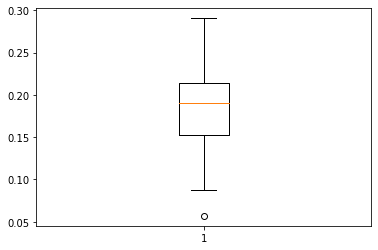

In [228]:
plt.boxplot(data["gch"].dropna())
plt.show()

In [225]:
# Violates non-normality!
data = data2data(
    iod_data = kb_iod, 
    lsc_data = kb_lsc, 
#     dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"top1"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
    baseline = "first"
)
res = OLS(data, "gch", ["cnt-ssc", "fpm_log"], transform_dep=True)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gch   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     14.58
Date:                Sat, 10 Feb 2024   Prob (F-statistic):           6.48e-06
Time:                        08:24:08   Log-Likelihood:                -4.1053
No. Observations:                  65   AIC:                             14.21
Df Residuals:                      62   BIC:                             20.73
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2842      0.318     -4.037      0.000      -1.920      -0.648
cnt-ssc        1.3234      0.518      2.552      0.013       0.287       2.360
fpm_log       -0.1360      0.052     -2.641      0.010      -0.239      -0.033
==============================================================================
Omnibus:                       14.453   Durbin-Watson:                   0.694
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.396
Skew:                           1.016   Prob(JB):                     0.000275
Kurtosis:                       4.386   Cond. No.                         66.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [222]:
data

,I-cnt,O-cnt,cnt-ssc,cnt-smx,I-cnt_dif,O-cnt_dif,cnt-ssc_dif,cnt-smx_dif,fpm,fpm_log,gch,rch,DW-YR
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N1_förortsgäng_2000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N1_förortsgäng_2001
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N1_förortsgäng_2002
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N1_förortsgäng_2003
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N1_förortsgäng_2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,0.360960,0.618764,0.368430,0.435903,0.017206,0.014206,0.005940,0.000738,6615.926424,3.820591,0.037057,8.030466,V1_berika_2017
84,0.343753,0.604559,0.362490,0.435166,0.013837,0.016266,0.002989,0.000597,3797.416718,3.579488,0.032271,3.708869,V1_berika_2018
85,0.357590,0.620825,0.365479,0.434569,0.012036,0.037100,0.006373,0.006168,5183.287060,3.714605,0.047342,6.721760,V1_berika_2019
86,0.345554,0.583725,0.371852,0.440737,0.004871,0.001169,0.003775,0.001488,4646.128226,3.667091,0.032579,2.267700,V1_berika_2020


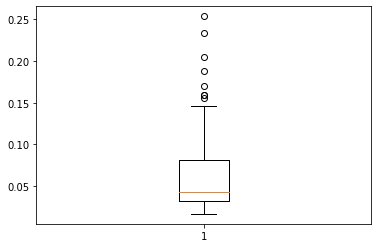

In [223]:
plt.boxplot(data["gch"].dropna())
plt.show()

In [230]:
data = data2data(
    iod_data = kb_iod, 
    lsc_data = kb_lsc, 
#     dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"top1"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
    baseline = "first"
)
res = OLS(data, "gch", ["cnt-ssc", "fpm_log"], transform_dep=True)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gch   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     14.58
Date:                Sat, 10 Feb 2024   Prob (F-statistic):           6.48e-06
Time:                        08:26:24   Log-Likelihood:                -4.1053
No. Observations:                  65   AIC:                             14.21
Df Residuals:                      62   BIC:                             20.73
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2842      0.318     -4.037      0.000      -1.920      -0.648
cnt-ssc        1.3234      0.518      2.552      0.013       0.287       2.360
fpm_log       -0.1360      0.052     -2.641      0.010      -0.239      -0.033
==============================================================================
Omnibus:                       14.453   Durbin-Watson:                   0.694
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.396
Skew:                           1.016   Prob(JB):                     0.000275
Kurtosis:                       4.386   Cond. No.                         66.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:

fig = sm.qqplot(res.resid)
plt.show()

In [ ]:
plt.hist(res.resid)
plt.show()

## Are the methods of measurement different?

* ***dif***<sub>*strategy*, *year*</sub> = `cnt` - `pwn`
* ***Mean***(*dif*)
* ***Min***(*dif*)
* ***Max***(*dif*)
* ***SD***(*dif*)
* ***correlation***(`cnt`, `pwn`)
* ***Overall*** vs. ***per term***

In [ ]:
def get_difs(df, M, years, corr):
    
    m1, m2 = M
    difs = []
    for year in years:
        #print(df[df["Method"] == m1][year])
        x = df[df["Method"] == m1][year].values[0]
        y = df[df["Method"] == m2][year].values[0]
        #dif = x - y
        dif = max(x,y) - min(x,y)
        
        #print(dif)
        
#         dif = dif.values.flatten().tolist()
        
        #print(dif)
        
        difs.append(dif)
        
    X = df[df["Method"]==m1][years].values.flatten()
    Y = df[df["Method"]==m2][years].values.flatten()
#     print(X)
#     print(Y)
    X, Y = zip(*[(x, y) for x,y in zip(X, Y) if not (pd.isna(x) or pd.isna(y))])
    
#     print(X)
#     print(Y)

    stat = corr(X, Y)
    r = stat.statistic
    N = len(X)
    
    return r, N, difs
    

In [ ]:
def compare_measures(iod_data, measures, years, corr = pearsonr, dwes = "all", aggregate = 1):
    """
    Compare measurement methods:
    param  iod_data   dataframe
    param  measures   tuple of measures, e.g. ("I-cnt", "I-pwn")
    param  aggregate  ... 
    """
    
    m1, m2 = measures
    
    if dwes == "all":
        dwes = set(iod_data["DWE"].values)
    else:
        assert isinstance(dwes, (list, tuple, set)), "`dwes` not iterable"
    
    dwes = list(dwes)
    dwes.sort()
    
    AB_strategies = sorted([col for col in iod_data.columns if col.lower().endswith("strategy")])
    if len(AB_strategies) == 1:
        strategies = list(set(iod_data[AB_strategies[0]].values))
    if len(AB_strategies) == 2:
#         print("AB", AB_strategies)
        A_strat = sorted(list(set(iod_data[AB_strategies[0]].values))) 
        B_strat = sorted(list(set(iod_data[AB_strategies[1]].values)))
        strategies = []
        for a in A_strat:
            for b in B_strat:
#                 print(a, b)
                strategies.append(f"{a}-{b}")
    
    
    if aggregate == 0:
        d = {dwe: {strategy: {"dif": None, "r": None} for strategy in strategies} for dwe in dwes}
    if aggregate == 1:
        d = {dwe: {"dif": [], "r": []} for dwe in dwes}
    if aggregate == 2:
        d = {"dif": [], "r": []}
    
    for dwe in dwes:
        
        if len(AB_strategies) == 1:
#             strategy = AB_strategies[0]
            for s in strategies:
                df = iod_data[(iod_data["DWE"] == dwe) & (iod_data["A-Strategy"] == s)]
                r, N, difs = get_difs(df, (m1, m2), years, corr)
                
                if aggregate == 0:
                    d[dwe][s]["r"] = r
                    d[dwe][s]["dif"] = difs
                    
                if aggregate == 1:
                    d[dwe]["r"].append(r)
                    d[dwe]["dif"].extend(difs)
                    
                if aggregate == 2:
                    d["r"].append(r)
                    d["dif"].extend(difs)
                
        
        if len(AB_strategies) == 2:
            
            for a in A_strat:
                for b in B_strat:
#                     print(a, b)
                    df = iod_data[(iod_data["DWE"] == dwe) & (iod_data["A-Strategy"] == a) & (iod_data["B-Strategy"] == b)]
                    r, N, difs = get_difs(df, (m1, m2), years, corr)
                    s = f"{a}-{b}"
                    #print(strategies.index(s))
                    
                    if aggregate == 0:
                        d[dwe][s]["r"] = r
                        d[dwe][s]["dif"] = difs

                    if aggregate == 1:
                        d[dwe]["r"].append(r)
                        d[dwe]["dif"].extend(difs)

                    if aggregate == 2:
                        d["r"].append(r)
                        d["dif"].extend(difs)
    
    results = []
    
    if aggregate == 0:
        for dwe in d.keys():
            for strategy in d[dwe].keys():
                dif = d[dwe][strategy]["dif"]
#                 print(d[dwe])
#                 print(d[dwe][strategy])
                to_results = {
                    "DWE" : dwe,
                    "Mdif"   : np.nanmean(dif),
                    "SDdif"  : np.nanstd(dif),
                    "MAXdif" : np.nanmax(dif),
                    "MINdif" : np.nanmin(dif),
                    "r"   : np.mean(d[dwe][strategy]["r"])
                }
                results.append(to_results)                
    if aggregate == 1:
        for dwe in d.keys():
            dif = d[dwe]["dif"]
            to_results = {
                "DWE"    : dwe,
                "Mdif"   : np.nanmean(dif),
                "SDdif"  : np.nanstd(dif),
                "MAXdif" : np.nanmax(dif),
                "MINdif" : np.nanmin(dif),
                "rM"      : np.mean(d[dwe]["r"])
            }
            results.append(to_results)
    if aggregate == 2:
        dif = d["dif"]
        to_results = {
            "DWE"    : None,
            "Mdif"   : np.nanmean(dif),
            "SDdif"  : np.nanstd(dif),
            "MAXdif" : np.nanmax(dif),
            "MINdif" : np.nanmin(dif),
            "rM"      : np.mean(d["r"])
        }
        results.append(to_results)        
        
    
    return pd.DataFrame(results)
            


## `cnt` vs. `pwn`?

### SGNS

In [ ]:
compare_measures(
    iod_data = sgns_iod, 
    measures = ("I-cnt", "I-pwn"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

In [ ]:
compare_measures(
    iod_data = sgns_iod, 
    measures = ("O-cnt", "O-pwn"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

Note: `N1_globalist`! A frequency effect?

### KB

In [ ]:
compare_measures(
    iod_data = kb_iod, 
    measures = ("I-cnt", "I-pwn"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

In [ ]:
compare_measures(
    iod_data = kb_iod, 
    measures = ("O-cnt", "O-pwn"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

### STS

In [ ]:
compare_measures(
    iod_data = sts_iod, 
    measures = ("I-cnt", "I-pwn"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

In [ ]:
compare_measures(
    iod_data = sts_iod, 
    measures = ("O-cnt", "O-pwn"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

**Summary:** Values of `cnt` and `pwn` are different, but *very* strongly correlated. The only exception is:

* SGNS-model
* Outgroup-dimension
* *globalist*

Here the correlation is 0.6 instead of 1.0. *Why?* (What is the "conceptual" difference between `cnt` and `pwn`? Consider Hamilton et al.).

## `ssc` vs. `smx`?

### SGNS

In [ ]:
compare_measures(
    iod_data = sgns_iod, 
    measures = ("cnt-ssc", "cnt-smx"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

Note: `N1_kulturberikare`

In [ ]:
compare_measures(
    iod_data = sgns_iod, 
    measures = ("pwn-ssc", "pwn-smx"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

Again, note: `N1_kulturberikare`, `V1_berika`

### STS

In [ ]:
compare_measures(
    iod_data = sts_iod, 
    measures = ("cnt-ssc", "cnt-smx"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

In [ ]:
compare_measures(
    iod_data = sts_iod, 
    measures = ("pwn-ssc", "pwn-smx"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

### KB

In [ ]:
compare_measures(
    iod_data = kb_iod, 
    measures = ("cnt-ssc", "cnt-smx"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

Note: `N1_globalist`

In [ ]:
compare_measures(
    iod_data = kb_iod, 
    measures = ("pwn-ssc", "pwn-smx"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

Note: `N1_globalist`

**Summary:** Values of `ssc` and `smx` are different, but very strongly correlated. Exceptions are:

|     |      `ssc`     |             `smx`          |
|-----|----------------|----------------------------|
|SNGS |*kulturberikare*|*kulturberikare*, *berikare*|
|KB   |*globalist*     |*globalist*                 |

*When less strongly correlated, why?* What is the "conceptual" difference between `ssc` and `smx`? Look at time plots. `smx` seems less variable, while `ssc` is more "responsive" to big gaps between ingroup and outgroup dimension.

## Visualization

In [ ]:
def viz(
    iod_data, 
    dwe, 
    criterion, 
    years, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True
):
    
    df = iod_data.copy()
    df = df[df["DWE"] == dwe]
    for col, val in criterion.items():
        df = df[df[col] == val]
    
    fig, ax = plt.subplots(figsize=(12,8))
    
    for m, c, l in meas:
        X = df[(df["DWE"] == dwe) & (df["Method"] == m)][years]
        if truncate:
            x, y = zip(*[(x, y) for x, y in zip(X.columns, X.values.flatten()) if not pd.isna(x) and not pd.isna(y)])
        else: 
            x = X.columns
            y = X.values.flatten()
            
        ax.plot(x, y, label=m, c=c, linestyle=l)
    ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncols=2)

    
    plt.show()
    
    

In [ ]:
def viz_multi(
    title,
    iod_data_frames,
    names,
    dwes, 
    criteria, 
    years, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True,
    ncols = 2
):
    
    dfs = []
    for D, criterion, dwe in zip(iod_data_frames, criteria, dwes):
        df = D.copy()
        df = df[df["DWE"] == dwe]
        for col, val in criterion.items():
            df = df[df[col] == val]
        dfs.append(df)

    NROWS  = ceil(len(dfs) / ncols)
    NCOLS  = ncols
    WIDTH  = 12 * NCOLS
    HEIGTH = NROWS * 6 
    
#    Y = years[[len(y) for y in years].index(max([len(y) for y in years]))]
#    Y = [int(y) for y in Y]
    
    fig, axs = plt.subplots(NROWS, NCOLS, figsize=(WIDTH,HEIGTH))

    for df, ax, yrs, name in zip(dfs, axs.flatten(), years, names):
        for m, c, l in meas:
#             X = df[(df["DWE"] == dwe) & (df["Method"] == m)][yrs]
            X = df[df["Method"] == m][yrs]
            
            if truncate:
                x, y = zip(*[(x, y) for x, y in zip(X.columns, X.values.flatten()) if not pd.isna(x) and not pd.isna(y)])
            else: 
                x = [int(c) for c in X.columns]
                y = X.values.flatten()

            ax.plot(x, y, label=m, c=c, linestyle=l)
            ax.set_title(name, fontsize=15)
            ax.set_xticks(range(len(x)))
            ax.set_xticklabels(x, rotation=35)#, ha='right')
            #ax.set_xticks(range(len(Y)+1), labels=Y)
        #ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncols=2)
            ax.legend()

    fig.suptitle(title, fontsize=25)
    plt.show()
    
    

### SGNS

In [ ]:
DWES = ["N1_förortsgäng", "N1_globalist", "V1_berika", "N1_återvandring"]
viz_multi(
    title = "SGNS: Flashback",
    iod_data_frames = [sgns_iod]*4, 
    names = DWES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*4,  
    years = [years]*4, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True)

In [ ]:
DWES = ["N1_globalist", "N1_globalist"]
viz_multi(
    title = "SGNS: globalist -- original & recoded",
    iod_data_frames = [sgns_iod, fb_sgns_G_iod], 
    names = DWES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*2,  
    years = [years]*2, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True)

In [ ]:
DWES = ["N1_globalist", "N1_globalist"]
viz_multi(
    title = "SGNS: globalist -- original & recoded",
    iod_data_frames = [sgns_iod, fb_sgns_G_iod], 
    names = DWES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"top3", "B-Strategy": "lazy"}]*2,  
    years = [years]*2, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True)

In [ ]:
DWES = ["N1_globalist", "N1_globalist"]
viz_multi(
    title = "SGNS: globalist -- original & recoded",
    iod_data_frames = [fm_sgns_iod, fm_sgns_G_iod], 
    names = DWES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*2,  
    years = [fm_years]*2, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True)

**Why has `O-cnt` changed??? Does not make any sense!**

In [ ]:
DWES = ["N1_förortsgäng", "N1_globalist", "V1_berika", "N1_återvandring"]
viz_multi(
    title = "SGNS: Flashback",
    iod_data_frames = [sgns_iod, fb_sgns_G_iod, sgns_iod, sgns_iod], 
    names = DWES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*4,  
    years = [years]*4, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True)

In [ ]:
DWES = ["N1_förortsgäng", "N1_globalist", "V1_berika", "N1_återvandring"]
viz_multi(
    title = "SGNS: Flashback",
    iod_data_frames = [sgns_iod]*4, 
    names = DWES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*4,  
    years = [years]*4, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-smx", "b", '--')], 
    truncate = True)

In [ ]:
# viz_multi(
#     title = "SGNS: Flashback",
#     iod_data_frames = [sgns_iod]*4, 
#     names = ["V1_berika", "V1_kulturberika", "N1_berikare", "N1_kulturberikare"],
#     dwes = ["V1_berika", "V1_kulturberika", "N1_berikare", "N1_kulturberikare"], 
#     criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*4,  
#     years = [years]*4, 
#     meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
#     truncate = True)

In [ ]:
viz_multi(
    title = "SGNS: Flashback",
    iod_data_frames = [sgns_iod]*2, 
    names = ["V1_återvandra", "N1_återvandring"],
    dwes = ["V1_återvandra", "N1_återvandring"], 
    criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*2,  
    years = [years]*2, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True)

In [ ]:
DWES = ["N1_återvandring","N1_globalist","V1_berika"]*2

NAMES = [f"{corpus}: {term}" for corpus, term in zip(DWES,["Flashback"]*3 + ["Familjeliv"]*3)]
#print(NAMES)

viz_multi(
    title = "SGNS",
    iod_data_frames = [sgns_iod]*3 + [fm_sgns_iod]*3, 
    names = NAMES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*6,  
    years = [years]*3 + [fm_years]*3, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True,
    ncols = 3
)

In [ ]:
DWES = ["N1_återvandring"]*2+["N1_globalist"]*2+["V1_berika"]*2
NAMES = [f"{corpus}: {term}" for corpus, term in zip(DWES,["Flashback", "Familjeliv"]*3)]
#print(NAMES)

viz_multi(
    title = "SGNS",
    iod_data_frames = [sgns_iod, fm_sgns_iod]*3, 
    names = NAMES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*6,  
    years = [years, fm_years]*3, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True)

In [ ]:
DWES = ["N1_återvandring"]*2+["N1_globalist"]*2+["V1_berika"]*2
NAMES = [f"{corpus}: {term}" for corpus, term in zip(DWES,["Flashback", "Familjeliv"]*3)]
#print(NAMES)

viz_multi(
    title = "SGNS",
    iod_data_frames = [sgns_iod, fm_sgns_iod] + [fb_sgns_G_iod, fm_sgns_G_iod,] + [sgns_iod, fm_sgns_iod], 
    names = NAMES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*6,  
    years = [years, fm_years]*3, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True)

In [ ]:
# viz_multi(
#     title = "SGNS: återvandring",
#     iod_data_frames = [sgns_iod, fm_sgns_iod], 
#     names = ["Flashback", "Familjeliv"],
#     dwes = ["N1_återvandring"]*2, 
#     criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*2,  
#     years = [years, fm_years], 
#     meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
#     truncate = True)

In [ ]:
# viz_multi(
#     title = "SGNS: globalist",
#     iod_data_frames = [sgns_iod, fm_sgns_iod], 
#     names = ["Flashback", "Familjeliv"],
#     dwes = ["N1_globalist"]*2, 
#     criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*2,  
#     years = [years, fm_years], 
#     meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
#     truncate = True)

In [ ]:
# viz_multi(
#     title = "SGNS: globalist",
#     iod_data_frames = [sgns_iod, fm_sgns_iod], 
#     names = ["Flashback", "Familjeliv"],
#     dwes = ["N1_globalist"]*2, 
#     criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*2,  
#     years = [years, fm_years], 
#     meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
#     truncate = True)

### KB

In [ ]:
DWES = ["N1_förortsgäng", "N1_globalist", "V1_berika", "N1_återvandring"]
viz_multi(
    title = "SBERT (KB, rn)",
    iod_data_frames = [kb_iod]*4, 
    names = DWES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"rn"}]*4,  
    years = [years]*4, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True)

In [ ]:
DWES = ["N1_globalist", "N1_globalist"]
viz_multi(
    title = "globalist: original & recoded:  FB, SBERT (KB, rn): ",
    iod_data_frames = [kb_iod, fb_kb_G_iod], 
    names = DWES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"rn"}]*2,  
    years = [years]*2, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True)

**Here, `O-cnt` are identical!**

In [ ]:
DWES = ["N1_förortsgäng", "N1_globalist", "V1_berika", "N1_återvandring"]
viz_multi(
    title = "SBERT (KB, top3)",
    iod_data_frames = [kb_iod]*4, 
    names = DWES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"top3"}]*4,  
    years = [years]*4, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True)

In [ ]:
# DWES = ["N1_förortsgäng", "N1_globalist", "V1_berika", "N1_återvandring"]
# viz_multi(
#     title = "SBERT (KB, ms1)",
#     iod_data_frames = [kb_iod]*4, 
#     names = DWES,
#     dwes = DWES, 
#     criteria = [{"A-Strategy":"ms1"}]*4,  
#     years = [years]*4, 
#     meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
#     truncate = True)

In [ ]:
DWES = ["N1_återvandring","N1_globalist","V1_berika"]*2

NAMES = [f"{corpus}: {term}" for corpus, term in zip(DWES,["Flashback"]*3 + ["Familjeliv"]*3)]
#print(NAMES)

viz_multi(
    title = "SBERT (KB)",
    iod_data_frames = [kb_iod]*3 + [fm_kb_iod]*3, 
    names = NAMES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"rn"}]*6,  
    years = [years]*3 + [fm_years]*3, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True,
    ncols = 3
)

In [ ]:
DWES = ["N1_återvandring"]*2+["N1_globalist"]*2+["V1_berika"]*2
NAMES = [f"{corpus}: {term}" for corpus, term in zip(DWES,["Flashback", "Familjeliv"]*3)]

viz_multi(
    title = "",
    iod_data_frames = [kb_iod, fm_kb_iod]*3, 
    names = NAMES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"rn"}]*6,  
    years = [years, fm_years]*3, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True,
    ncols = 2
)

In [ ]:
# DWES = ["N1_förortsgäng", "N1_globalist", "V1_berika", "N1_återvandring"]
# viz_multi(
#     title = "SBERT (STS)",
#     iod_data_frames = [sts_iod]*4, 
#     names = DWES,
#     dwes = DWES, 
#     criteria = [{"A-Strategy":"rn"}]*4,  
#     years = [years]*4, 
#     meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
#     truncate = True)

In [ ]:
#viz(sgns_iod, "N1_återvandring", {"A-Strategy":"ms1", "B-Strategy": "top3"}, years)

In [ ]:
#viz(fm_sgns_iod, "N1_återvandring", {"A-Strategy":"ms1", "B-Strategy": "top3"}, fm_years)

In [ ]:
#viz(sts_iod, "N1_återvandring", {"A-Strategy":"ms1"}, years)

In [ ]:
#viz(sgns_iod, "N1_förortsgäng", {"A-Strategy":"ms1", "B-Strategy": "top3"}, years)

In [ ]:
#viz(sts_iod, "N1_förortsgäng", {"A-Strategy":"top3"}, years)

In [ ]:
#viz(sgns_iod, "N1_globalist", {"A-Strategy":"ms1", "B-Strategy": "top3"}, years)

In [ ]:
#viz(sts_iod, "N1_globalist", {"A-Strategy":"top3"}, years)

In [ ]:
#viz(sgns_iod, "V1_berika", {"A-Strategy":"ms1", "B-Strategy": "top3"}, years)

In [ ]:
#viz(kb_iod, "V1_berika", {"A-Strategy":"ms1"}, years)

In [ ]:
#viz(sgns_iod, "N1_berikare", {"A-Strategy":"ms1", "B-Strategy": "top3"}, years)

In [ ]:
#viz(sts_iod, "N1_berikare", {"A-Strategy":"rn"}, years)

## ... ingroupness in FB and  FL

In [ ]:
fm_sgns_lsc.index

In [ ]:
def t(iodA, yA, iodB, yB, dwes, criterion, method, collapse = False, ks=False, drop_from_results=["alternative","BF10", "power"]):
    
    dfA = iodA.copy()
    dfB = iodB.copy()
    
    criterion["Method"] = method
    
    for var, val in criterion.items():
        dfA = dfA[dfA[var]==val]
        dfB = dfB[dfB[var]==val]
    
    dfA.set_index("DWE", inplace=True)
    dfB.set_index("DWE", inplace=True)
    
    dfA = dfA.loc[dwes]
    dfB = dfB.loc[dwes]
    
    dfA = dfA[yA]
    dfB = dfB[yB]
    
    if collapse:
        A = dfA.values.flatten()
        B = dfB.values.flatten()
        if ks:
            return ks_2samp(A,B)
        results = pg.ttest(A,B)
        for exclude in drop_from_results:
            results.drop(exclude, axis=1, inplace=True)
            
        results["M_A"] = np.nanmean(A) 
        results["M_B"] = np.nanmean(B)
        results["N_A"] = len([a for a in A if not pd.isna(a)])
        results["N_B"] = len([b for b in B if not pd.isna(b)])
        return results
    else:
        results = []
        for dwe in dwes:
            A = dfA.loc[dwe].values.flatten()
            B = dfB.loc[dwe].values.flatten()
            result = pg.ttest(A,B)
            for exclude in drop_from_results:
                result.drop(exclude, axis=1, inplace=True)
            
            result["Term"] = dwe
            result["M_A"] = np.nanmean(A)
            result["sd_A"] = np.nanstd(A)
            result["N_A"] = len([a for a in A if not pd.isna(a)])
            result["M_B"] = np.nanmean(B)
            result["sd_B"] = np.nanstd(B)            
            result["N_B"] = len([b for b in B if not pd.isna(b)])
            results.append(result)
        results = pd.concat(results)
        results.set_index("Term", inplace=True)
        return results.round(3)
            
    

### SGNS

In [ ]:
results = t(
    sgns_iod, 
    years, 
    fm_sgns_iod, 
    fm_years, 
    fm_sgns_lsc.index, 
    {"A-Strategy":"ms1", "B-Strategy": "top3"},
    "cnt-smx",
    collapse=False,
    #ks=True
)
#print(results.to_latex(float_format="{:.3f}".format))
results

In [ ]:
results = t(
    fb_sgns_G_iod, 
    years, 
    fm_sgns_G_iod, 
    fm_years, 
    ["N1_globalist"], 
    {"A-Strategy":"ms1", "B-Strategy": "top3"},
    "cnt-smx",
    collapse=False,
    #ks=True
)
#print(results.to_latex(float_format="{:.3f}".format))
results

In [ ]:
results = t(
    fb_sgns_G_iod, 
    years, 
    fm_sgns_G_iod, 
    fm_years, 
    ["N1_globalist"], 
    {"A-Strategy":"top3", "B-Strategy": "min0.2"},
    "I-cnt",
    collapse=False,
    #ks=True
)
#print(results.to_latex(float_format="{:.3f}".format))
results

For every combination, GLOABLIST is more ingroup in familjeliv! 

In [ ]:
t(
    sgns_iod, 
    years, 
    fm_sgns_iod, 
    fm_years, 
    fm_sgns_lsc.index, 
    {"A-Strategy":"ms1", "B-Strategy": "top3"},
    "cnt-ssc",
    collapse=False,
    #ks=True
)

In [ ]:
t(
    sgns_iod, 
    years, 
    fm_sgns_iod, 
    fm_years, 
    fm_sgns_lsc.index, 
    {"A-Strategy":"ms1", "B-Strategy": "top3"},
    "pwn-smx",
    collapse=False,
    #ks=True
)

**Obs!** `V1_återvandra`

In [ ]:
t(
    sgns_iod, 
    years, 
    fm_sgns_iod, 
    fm_years, 
    fm_sgns_lsc.index, 
    {"A-Strategy":"ms1", "B-Strategy": "top3"},
    "pwn-ssc",
    collapse=False,
    #ks=True
)

**Obs!** `V1_återvandra`

### KB

In [ ]:
set(kb_iod["A-Strategy"])

In [ ]:
results = t(
    kb_iod, 
    years, 
    fm_kb_iod, 
    fm_years, 
    fm_sgns_lsc.index, 
    {"A-Strategy":"rn"},
    "cnt-smx",
    collapse=False,
    #ks=True
)
#print(results.to_latex(float_format="{:.3f}".format))
results

In [ ]:
results = t(
    kb_iod, 
    years, 
    fm_kb_iod, 
    fm_years, 
    fm_sgns_lsc.index, 
    {"A-Strategy":"ms1"},
    "cnt-ssc",
    collapse=False,
    #ks=True
)
#print(results.to_latex(float_format="{:.3f}".format))
results

In [ ]:
# results = t(
#     fb_kb_G_iod, 
#     years, 
#     fm_kb_G_iod, 
#     fm_years, 
#     fm_sgns_lsc.index, 
#     {"A-Strategy":"rn"},
#     "cnt-smx",
#     collapse=False,
#     #ks=True
# )
# #print(results.to_latex(float_format="{:.3f}".format))
# results

In [ ]:
t(
    kb_iod, 
    years, 
    fm_kb_iod, 
    fm_years, 
    fm_sgns_lsc.index, 
    {"A-Strategy":"rn"},
    "cnt-ssc",
    collapse=False,
    #ks=True
)

In [ ]:
t(
    kb_iod, 
    years, 
    fm_kb_iod, 
    fm_years, 
    fm_sgns_lsc.index, 
    {"A-Strategy":"rn"},
    "pwn-smx",
    collapse=False,
    #ks=True
)

In [ ]:
t(
    fb_kb_G_iod, 
    years, 
    fm_kb_G_iod, 
    fm_years, 
    ["N1_globalist"], 
    {"A-Strategy":"ms1"},
    "pwn-ssc",
    collapse=False,
    #ks=True
)

## Correlation

In [ ]:
d = sgns_iod[sgns_iod["DWE"] == "V1_berika"][years].transpose().corr()

plt.imshow(d, cmap=plt.cm.rainbow, interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
def compare(iod_data, term, criterion, method=pearsonr, years = years, add_mean=False):
    
    used = years + list(criterion.keys()) + ["DWE"]
    remains = [col for col in iod_data.columns if col not in used]
    #print(remains)

    df = iod_data.copy()
    df = df[df["DWE"] == term]
    
    if type(criterion) == dict:
        criterion = criterion.items()
    for var, val in criterion:
        df = df[df[var]==val]
    
    df = df[years]
    
    #return df
    
    labels = ["-".join(iod_data.loc[i][remains].to_list()) for i in df.index]
    
    df["labels"] = labels
    df = df.set_index("labels")
    
    correlations = df.transpose().corr().round(3)
    
    if add_mean:
        correlations["Mean"] = correlations.mean(axis=1)
    
    return correlations
    
#     plt.imshow(correlations, cmap=plt.cm.rainbow, interpolation='nearest')
#     plt.colorbar()
#     plt.show()
    

In [ ]:
#sgns_iod

In [ ]:
#fm_sgns_iod

In [ ]:
compare(iod_data=sgns_iod, term="V1_berika", criterion={"A-Strategy":"ms1", "B-Strategy": "top3"}, years=years)

In [ ]:
# x =  fm_sgns_iod.drop("2022", axis=1)
# compare(iod_data=x, term="V1_berika", criterion={"A-Strategy":"ms1", "B-Strategy": "top3"}, years=fm_years)

## Correlation of Selection Strategies

### SGNS

#### Återvandring

In [ ]:
compare(iod_data=sgns_iod, term="N1_återvandring", criterion={"Method":"I-cnt"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="N1_återvandring", criterion={"Method":"cnt-ssc"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="N1_återvandring", criterion={"Method":"I-cnt", "A-Strategy":"ms1"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="N1_återvandring", criterion={"Method":"I-cnt", "A-Strategy": "top3"})

#### Berika

In [ ]:
compare(iod_data=sgns_iod, term="V1_berika", criterion={"Method":"I-cnt"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="V1_berika", criterion={"Method":"I-cnt", "A-Strategy":"ms1"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="V1_berika", criterion={"Method":"I-cnt", "A-Strategy": "top3"})

##### Kulturberika

In [ ]:
compare(iod_data=sgns_iod, term="V1_kulturberika", criterion={"Method":"I-cnt"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="V1_kulturberika", criterion={"Method":"I-cnt", "A-Strategy":"ms1"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="V1_kulturberika", criterion={"Method":"I-cnt", "A-Strategy": "top3"})

#### Förortsgäng

In [ ]:
compare(iod_data=sgns_iod, term="N1_förortsgäng", criterion={"Method":"I-cnt"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="N1_förortsgäng", criterion={"Method":"I-cnt", "A-Strategy":"ms1"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="N1_förortsgäng", criterion={"Method":"I-cnt", "A-Strategy": "top3"})

#### Globalist

In [ ]:
compare(iod_data=sgns_iod, term="N1_globalist", criterion={"Method":"I-cnt"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="N1_globalist", criterion={"Method":"cnt-ssc"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="N1_globalist", criterion={"Method":"I-cnt", "A-Strategy":"ms1"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="N1_globalist", criterion={"Method":"I-cnt", "A-Strategy": "top3"})

## Correlation of *I* and *O*

Ingroup and outgroup are to a large extent correlated. For the SGNS models this is kind of expected given the semantic space the embeddings are trained in. For the SBERT-KB models this is more surprising. 

### SGNS - Flashback

In [ ]:
correlations = []
for term in fm_sgns_lsc.index:
    r = compare(iod_data=sgns_iod, term=term, criterion={"A-Strategy":"ms1", "B-Strategy": "top3"}, years=years)
    score = r.loc["I-cnt"]["O-cnt"]
    correlations.append(score)
df1 = pd.DataFrame(correlations, index = fm_sgns_lsc.index, columns = ["r-sgns-fb"])
df1

In [ ]:
correlations = []
for term in fm_sgns_lsc.index:
    r = compare(iod_data=sgns_iod, term=term, criterion={"A-Strategy":"top3", "B-Strategy": "lazy"}, years=years)
    score = r.loc["I-cnt"]["O-cnt"]
    correlations.append(score)
df1 = pd.DataFrame(correlations, index = fm_sgns_lsc.index, columns = ["r-sgns-fb"])
df1

### SGNS - Familjeliv

In [ ]:
x = fm_sgns_iod.drop("2022", axis=1)
correlations = []

for term in fm_sgns_lsc.index:
    r = compare(iod_data=x, term=term, criterion={"A-Strategy":"ms1", "B-Strategy": "top3"}, years=fm_years)
    score = r.loc["I-cnt"]["O-cnt"]
    correlations.append(score)
df2 = pd.DataFrame(correlations, index = fm_sgns_lsc.index, columns = ["r-sgns-fl"])
df2

### SBERT - Flashback

In [ ]:
correlations = []
for term in fm_sgns_lsc.index:
    r = compare(iod_data=kb_iod, term=term, criterion={"A-Strategy":"rn"}, years=years)
    score = r.loc["I-cnt"]["O-cnt"]
    correlations.append(score)
df3 = pd.DataFrame(correlations, index = fm_sgns_lsc.index, columns = ["r-sbert-fb"])
df3

In [ ]:
correlations = []
for term in fm_sgns_lsc.index:
    r = compare(iod_data=kb_iod, term=term, criterion={"A-Strategy":"top3"}, years=years)
    score = r.loc["I-cnt"]["O-cnt"]
    correlations.append(score)
df3 = pd.DataFrame(correlations, index = fm_sgns_lsc.index, columns = ["r-sbert-fb"])
df3

STS:

In [ ]:
correlations = []
for term in fm_sgns_lsc.index:
    r = compare(iod_data=sts_iod, term=term, criterion={"A-Strategy":"rn"}, years=years)
    score = r.loc["I-cnt"]["O-cnt"]
    correlations.append(score)
df3 = pd.DataFrame(correlations, index = fm_sgns_lsc.index, columns = ["r-sbert-fb"])
df3

### SBERT - Familjeliv

In [ ]:
#x = fm_kb_iod.drop("2022", axis=1)
correlations = []

for term in fm_sgns_lsc.index:
    r = compare(iod_data=fm_kb_iod, term=term, criterion={"A-Strategy":"rn"}, years=fm_years)
    score = r.loc["I-cnt"]["O-cnt"]
    correlations.append(score)
df4 = pd.DataFrame(correlations, index = fm_sgns_lsc.index, columns = ["r-sbert-fl"])
df4

In [ ]:
print(pd.concat([df1, df2, df3, df4], axis=1).to_latex(float_format="{:.3f}".format))

## Correlation external variables

In [ ]:
def correlation(
    iod_data, 
    iod_var, 
    lsc_data, 
    lsc_var, 
    norm_iod = None,
    norm_lsc = None,
    method=pearsonr, 
    only_sign = True, 
    years = years,
    difference = False,
    baseline = "first" # first or second year of pair (t_i, t_j)
):
    
    results = []
    
    if type(iod_var) == dict:
        iod_var = iod_var.items()
        
    X = iod_data.copy()
    for var, val in iod_var:
        X = X[X[var]==val]
    
    if lsc_var == "fpm":
        X = X[[str(y) for y in years]]
    else:
        if difference:
#             transitions = [f"{str(year)[2:]}:{str(int(year)+1)[2:]}" for year in years[:-1]]
            transitions = [f"{str(year)}:{str(int(year)+1)}" for year in years[:-1]]
            X = X[transitions]
        else:
            if baseline == "first":
                X = X[[str(y) for y in years[:-1]]]
            if baseline == "second":
                X = X[[str(y) for y in years[1:]]]
   
    col = [v for v in lsc_data.columns if v.startswith(lsc_var)]
    #col = [v for v in lsc_data.columns if v.startswith(lsc_var)][:-1]
    
#     for a, b, in zip(X.columns, col):
#         print(a, b)
#     print("----")
    
    idx = []
    for i in X.index:
        x = X.loc[i]
        dwe = iod_data.iloc[i]["DWE"]
        if dwe not in lsc_data.index:
            continue
        y = lsc_data.loc[dwe][col]
        
        x,y = zip(*[(a,b) for a,b in zip(x,y) if not pd.isna(a) and not pd.isna(b)])
        
        if norm_iod:
            x = norm_iod(x)
        if norm_lsc:
            y = norm_lsc(y)
            
        
        N = len(x)

        stat = method(x, y)
        
        d = {
            "Corr": stat[0],
            "p": stat[1],
            "N": N,
        }
        
        if only_sign:
            if stat[1] < 0.05:
                idx.append(i)
                results.append(d)
        else:
            idx.append(i)
            results.append(d)
    
    df = pd.DataFrame(results, index=idx)
    headings = [h for h in iod_data.columns if not any(ch.isdigit() for ch in h)]
    df = pd.concat([iod_data.loc[idx][headings], df], axis=1)
    
    return df
    

In [ ]:
def ConCat(feature, base_criterion, measures, iod, lsc, years, baseline):
    results = []
    criterion = dict(base_criterion)
    for m in sorted(measures):
        criterion["Method"] = m
        df = correlation(iod, criterion, lsc, feature, years = years, method=pearsonr, only_sign = False, baseline=baseline)
        df.set_index("DWE", inplace=True)
#         print(df)
#         break
        N = df["N"]
        df = df[["Corr", "p"]]
        df.rename({"Corr":m}, axis=1, inplace=True)
        results.append(df)
    results.append(N)
    return pd.concat(results, axis=1).round(3)

In [ ]:
#ConCat("gch", standard, measures_cnt + measures_pwn, sgns_iod, sgns_lsc, years, baseline="first")

In [ ]:
#ConCat("gch", standard, measures_cnt + measures_pwn, sgns_iod, sgns_lsc, years, baseline="second")

In [ ]:
def pwalk(
    iod_data, 
    #iod_var, 
    lsc_data, 
    lsc_var, 
    norm_iod = None,
    norm_lsc = None,
    method=pearsonr, 
    s_combos = "all",
    iod_methods = ["I-cnt", "O-cnt", "cnt-ssc"],
    #only_sign = True, 
    years = years,
    criterion = "p",
    binary = True,
    threshold = 0.05,
    add_total = True
    ):
    
    dfs = []
    
    if s_combos == "all":
        combos = []
        col = [c for c in iod_data.columns if c.lower().endswith("strategy")]
        
        if len(col) == 1:
            val = set(iod_data[col[0]].values)
            for v in val:
                for m in iod_methods:
                    combos.append({col[0]:v,"Method":m})
        if len(col) == 2:
            val1 = set(iod_data[col[0]].values)
            val2 = set(iod_data[col[1]].values)
            for v1 in val1:
                for v2 in val2:
                    for m in iod_methods:
                        combos.append({col[0]:v1, col[1]: v2, "Method":m})            
    
#    print(combos)
    
    key = {}
    
    for combo in combos:
        
        df = correlation(
            iod_data=iod_data, 
            iod_var=combo, 
            lsc_data=lsc_data, 
            lsc_var=lsc_var, 
            norm_iod=norm_iod, 
            norm_lsc=norm_lsc, 
            method=method, 
            only_sign=False, 
            years=years)
        
        #return df["p"]
        
        if binary:
            df[criterion] = df[criterion] < threshold
            df[criterion] = df[criterion].astype(int)
        
        name = "-".join([f"{var}:{val}" for var, val in combo.items()])
#         df = df[criterion]

        if list(key.values()) == []:
            key[name] = 0
        else:
            key[name] = max(key.values())+1
        
        df = df.rename({criterion: key[name]}, axis=1)
        df.set_index("DWE", inplace=True)
        df = df[key[name]]
        
        dfs.append(df)
        
    results = pd.concat(dfs, axis=1)
    if add_total:
        results.loc['Column_Total'] = results.sum(numeric_only=True, axis=0)
#         results = results.append(results.sum(numeric_only=True), ignore_index=True)
        
    
    return results, key
        
    

In [ ]:
def maximizer(df, key):
    col_idx = df.loc["Column_Total"].idxmax(axis=0)
    combo = dict([(v, k) for k, v in key.items()])
    return combo[col_idx], key[combo[col_idx]]

In [ ]:
#ConCat("gch", standard, measures_cnt + measures_pwn, fm_sgns_iod, fm_sgns_lsc, fm_years)

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "I-cnt", "A-Strategy":"top3", "B-Strategy":"min0.2"}, 
    sgns_lsc, 
    "rch",
    method=pearsonr, 
    only_sign=False,
    difference = True
)

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    sgns_lsc, 
    "gch",
    method=pearsonr, 
    only_sign=False,
    difference = False,
    baseline="first"
)

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    sgns_lsc, 
    "gch",
    method=pearsonr, 
    only_sign=False,
    difference = False,
    baseline = "second"
)

## Correlation FPM

### SGNS

In [ ]:
df, key = pwalk(
    iod_data = sgns_iod, 
    #iod_var, 
    lsc_data = sgns_lsc, 
    lsc_var = "fpm", 
    norm_iod = None,
    norm_lsc = np.log10,
    method=pearsonr, 
    s_combos = "all",
    iod_methods = ["I-cnt", "O-cnt", "cnt-ssc"],
    #only_sign = True, 
    years = years,
    criterion = "p",
    binary = True,
    threshold = 0.05    
    )
maximizer(df, key)

In [ ]:
df

In [ ]:
df.loc[:, df.loc["Column_Total"] > 4].rename({v:k for k,v in key.items()}, axis=1)

In [ ]:
correlation(sgns_iod, {'A-Strategy':'ms1','B-Strategy':'min0.2','Method':'I-cnt'}, sgns_lsc, "fpm", norm_lsc = np.log10, method=pearsonr)

In [ ]:
correlation(sgns_iod, {"A-Strategy":"ms1", "B-Strategy":"top3",'Method':'I-cnt'}, sgns_lsc, "fpm", norm_lsc = np.log10, method=pearsonr)

In [ ]:
#

In [ ]:
fpm["DWE"].value_counts()

In [ ]:
fpm["A-Strategy"].value_counts()

In [ ]:
fpm["B-Strategy"].value_counts()

In [ ]:
fpm["Method"].value_counts()

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    sgns_lsc, 
    "fpm",
    norm_lsc = np.log10,
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    sgns_lsc, 
    "fpm", 
    norm_lsc = np.log10,
    method=pearsonr, 
    only_sign=False
)

### STS

In [ ]:
fpm = correlation(sts_iod, {}, sts_lsc, "fpm", method=pearsonr); fpm

In [ ]:
fpm["DWE"].value_counts()

In [ ]:
fpm["A-Strategy"].value_counts()

In [ ]:
fpm["Method"].value_counts()

In [ ]:
correlation(
    sts_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1"}, 
    sts_lsc, 
    "fpm", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sts_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1"}, 
    sts_lsc, 
    "fpm", 
    method=pearsonr, 
    only_sign=False
)

### KB

In [ ]:
df, key = pwalk(
    iod_data = kb_iod, 
    #iod_var, 
    lsc_data = kb_lsc, 
    lsc_var = "fpm", 
    norm_iod = None,
    norm_lsc = np.log10,
    method=pearsonr, 
    s_combos = "all",
    iod_methods = ["I-cnt", "O-cnt", "cnt-ssc"],
    #only_sign = True, 
    years = years,
    criterion = "p",
    binary = True,
    threshold = 0.05    
    )
df

In [ ]:
fpm = correlation(kb_iod, {}, kb_lsc, "fpm", method=pearsonr); fpm

In [ ]:
fpm["DWE"].value_counts()

In [ ]:
fpm["A-Strategy"].value_counts()

In [ ]:
fpm["Method"].value_counts()

In [ ]:
correlation(
    kb_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"rn"}, 
    kb_lsc, 
    "fpm", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    kb_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1"}, 
    kb_lsc, 
    "fpm", 
    method=pearsonr, 
    only_sign=False
)

## Correlation Naive Change

* Optimal method vs "standard" (`{"A-Strategy":"ms1", "B-Strategy":"top3"}` / `{"A-Strategy":"rn"}'`)
* CNT vs PWN
* O, I, ssc
* FB, FL
* SGNS, SBERT

### SGNS

#### Background

##### PWN

In [ ]:
df, key = pwalk(
    iod_data = sgns_iod, 
    #iod_var, 
    lsc_data = sgns_lsc, 
    lsc_var = "gch", 
    norm_iod = None,
    norm_lsc = None,
    method=pearsonr, 
    s_combos = "all",
    iod_methods = ["I-pwn", "O-pwn", "pwn-ssc"],
    #only_sign = True, 
    years = years,
    criterion = "p",
    binary = True,
    threshold = 0.05    
    )
maximizer(df, key)

In [ ]:
df

In [ ]:
#df.loc[:, df.loc["Column_Total"] > 0]

##### CNT

In [ ]:
df, key = pwalk(
    iod_data = sgns_iod, 
    #iod_var, 
    lsc_data = sgns_lsc, 
    lsc_var = "gch", 
    norm_iod = None,
    norm_lsc = None,
    method=pearsonr, 
    s_combos = "all",
    iod_methods = ["I-cnt", "O-cnt", "cnt-ssc"],
    #only_sign = True, 
    years = years,
    criterion = "p",
    binary = True,
    threshold = 0.05    
    )
maximizer(df, key)

In [ ]:
df

In [ ]:
#df.loc[:, df.loc["Column_Total"] > 0].rename({v:k for k,v in key.items()}, axis=1)
#df.loc[:, df.loc["Column_Total"] > 0]

#### Summary - "GCH"

In [ ]:
standard   = {"A-Strategy":"ms1",  "B-Strategy":"top3"}
opptim_pwn = {'A-Strategy':'ms1',  'B-Strategy':'min0.2'}
opptim_cnt = {'A-Strategy':'top3', 'B-Strategy':'lazy'}

measures_cnt = ["I-cnt", "O-cnt", "cnt-ssc"]
measures_pwn = ["I-pwn", "O-pwn", "pwn-ssc"]

Flashback

In [ ]:
ConCat("gch", standard, measures_cnt + measures_pwn, sgns_iod, sgns_lsc, years, baseline="second")

In [ ]:
res = ConCat("gch", standard, measures_cnt + measures_pwn, sgns_iod, sgns_lsc, years, baseline="second")
print(res.to_latex(float_format="{:.2f}".format))

In [ ]:
sns.heatmap(
    ConCat(
        "gch", 
        opptim_cnt, 
        measures_cnt + measures_pwn, 
        sgns_iod, 
        sgns_lsc, 
        years, 
        baseline="second"
    ).drop(["p", "N"], axis=1),
    annot=True
)

In [ ]:
ConCat("gch", opptim_cnt, measures_cnt + measures_pwn, sgns_iod, sgns_lsc, years, baseline="second")

In [ ]:
 ConCat("gch", opptim_pwn, measures_cnt + measures_pwn, sgns_iod, sgns_lsc, years)

Familjeliv

In [ ]:
ConCat("gch", standard, measures_cnt + measures_pwn, fm_sgns_iod, fm_sgns_lsc, fm_years, baseline="second")

In [ ]:
res = ConCat("gch", standard, measures_cnt + measures_pwn, fm_sgns_iod, fm_sgns_lsc, fm_years, baseline="second")
print(res.to_latex(float_format="{:.2f}".format))

### KB

Flashback

In [ ]:
standard = {"A-Strategy":"rn"}
res = ConCat("gch", standard, measures_cnt + measures_pwn, kb_iod, kb_lsc, years, baseline="second")
#print(res.to_latex(float_format="{:.2f}".format))
res

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
res = ConCat("gch", {"A-Strategy":"top1"}, measures_cnt + measures_pwn, kb_iod, kb_lsc, years, baseline="second")
#print(res.to_latex(float_format="{:.2f}".format))
res.drop(["p", "N"],axis=1,inplace=True)
sns.heatmap(res, annot=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
res = ConCat("gch", {"A-Strategy":"rn"}, measures_cnt + measures_pwn, kb_iod, kb_lsc, years, baseline="second")
#print(res.to_latex(float_format="{:.2f}".format))
res.drop(["p", "N"],axis=1,inplace=True)
sns.heatmap(res, annot=True)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))

res = ConCat("gch", {"A-Strategy":"rn"}, measures_cnt + measures_pwn, kb_iod, kb_lsc, years, baseline="second")
#print(res.to_latex(float_format="{:.2f}".format))
res.drop(["p", "N"],axis=1,inplace=True)
sns.heatmap(res, annot=True, ax=axs[0])
axs[0].set_title("Really Naive")

res = ConCat("gch", {"A-Strategy":"top3"}, measures_cnt + measures_pwn, kb_iod, kb_lsc, years, baseline="second")
#print(res.to_latex(float_format="{:.2f}".format))
res.drop(["p", "N"],axis=1,inplace=True)
sns.heatmap(res, annot=True, ax = axs[1])
axs[1].set_title("Top3")

plt.show()

In [ ]:
# standard = {"A-Strategy":"rn"}
# res = ConCat("gch", standard, measures_cnt + measures_pwn, fb_kb_G_iod, kb_lsc, years, baseline="second")
# #print(res.to_latex(float_format="{:.2f}".format))
# res

Familjliv

In [ ]:
# standard = {"A-Strategy":"rn"}
# res = ConCat("gch", standard, measures_cnt + measures_pwn, fm_kb_iod, fm_kb_lsc, fm_years, baseline="second")
# print(res.to_latex(float_format="{:.2f}".format))
# res

In [ ]:
df, key = pwalk(
    iod_data = kb_iod, 
    #iod_var, 
    lsc_data = kb_lsc, 
    lsc_var = "gch", 
    norm_iod = None,
    norm_lsc = None,
    method=pearsonr, 
    s_combos = "all",
    iod_methods = ["I-cnt", "O-cnt", "cnt-ssc"],
    #only_sign = True, 
    years = years,
    criterion = "p",
    binary = True,
    threshold = 0.05    
    )
maximizer(df, key)

In [ ]:
df

In [ ]:
df.loc[:, df.loc["Column_Total"] > 3].rename({v:k for k,v in key.items()}, axis=1)
#df.loc[:, df.loc["Column_Total"] > 3]

In [ ]:
correlation(kb_iod, {'A-Strategy':'top1','Method':'O-cnt'}, kb_lsc, "gch", method=pearsonr)

In [ ]:
correlation(kb_iod, {'A-Strategy':'top1','Method':'I-cnt'}, kb_lsc, "gch", method=pearsonr)

In [ ]:
correlation(kb_iod, {'A-Strategy':'rn','Method':'O-cnt'}, kb_lsc, "gch", method=pearsonr)

In [ ]:
correlation(kb_iod, {'A-Strategy':'rn','Method':'I-cnt'}, kb_lsc, "gch", method=pearsonr)

In [ ]:
gch = correlation(kb_iod, {}, kb_lsc, "gch", method=pearsonr); gch

In [ ]:
gch["DWE"].value_counts()

In [ ]:
gch["A-Strategy"].value_counts()

In [ ]:
gch["Method"].value_counts()

In [ ]:
sgns_iod["A-Strategy"].value_counts()

In [ ]:
correlation(
    kb_iod, 
    {"Method": "I-cnt", "A-Strategy":"rn"}, 
    kb_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
).round(3)

In [ ]:
correlation(
    kb_iod, 
    {"Method": "I-cnt", "A-Strategy":"nno"}, 
    kb_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
).round(3)

In [ ]:
correlation(
    kb_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1"}, 
    kb_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
).round(3)

In [ ]:
correlation(
    kb_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"rn"}, 
    kb_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
).round(3)

In [ ]:
correlation(
    kb_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"top3"}, 
    kb_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
).round(3)

### STS

In [ ]:
df, key = pwalk(
    iod_data = sts_iod, 
    #iod_var, 
    lsc_data = sts_lsc, 
    lsc_var = "gch", 
    norm_iod = None,
    norm_lsc = None,
    method=pearsonr, 
    s_combos = "all",
    iod_methods = ["I-cnt", "O-cnt", "cnt-ssc"],
    #only_sign = True, 
    years = years,
    criterion = "p",
    binary = True,
    threshold = 0.05    
    )
maximizer(df, key)

In [ ]:
df

In [ ]:
#df.loc[:, df.loc["Column_Total"] > 0].rename({v:k for k,v in key.items()}, axis=1)
df.loc[:, df.loc["Column_Total"] > 4]

In [ ]:
gch = correlation(sts_iod, {}, sts_lsc, "gch", method=pearsonr); gch

In [ ]:
gch["DWE"].value_counts()

In [ ]:
gch["A-Strategy"].value_counts()

In [ ]:
gch["Method"].value_counts()

In [ ]:
sgns_iod["A-Strategy"].value_counts()

In [ ]:
correlation(
    sts_iod, 
    {"Method": "I-cnt", "A-Strategy":"rn"}, 
    sts_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
).round(2)

In [ ]:
correlation(
    sts_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1"}, 
    sts_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sts_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1"}, 
    sts_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sts_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"top3"}, 
    sts_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
)

## Correlation Rectified Change

In [ ]:
standard   = {"A-Strategy":"ms1",  "B-Strategy":"top3"}
opptim_pwn = {'A-Strategy':'ms1',  'B-Strategy':'min0.2'}
opptim_cnt = {'A-Strategy':'top3', 'B-Strategy':'lazy'}

measures_cnt = ["I-cnt", "O-cnt", "cnt-ssc"]
measures_pwn = ["I-pwn", "O-pwn", "pwn-ssc"]

In [ ]:
res = ConCat("rch", standard, measures_cnt + measures_pwn, sgns_iod, sgns_lsc, years, baseline="second")
print(res.to_latex(float_format="{:.2f}".format))

In [ ]:
standard = {"A-Strategy":"rn"}
res = ConCat("rch", standard, measures_cnt + measures_pwn, kb_iod, kb_lsc, years, baseline="second")
print(res.to_latex(float_format="{:.2f}".format))
res

### SGNS

In [ ]:
rch = correlation(sgns_iod, {}, sgns_lsc, "rch", method=pearsonr); rch

In [ ]:
rch["DWE"].value_counts()

In [ ]:
rch["A-Strategy"].value_counts()

In [ ]:
rch["B-Strategy"].value_counts()

In [ ]:
rch["Method"].value_counts()

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    sgns_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1", "B-Strategy":"top3"}, 
    sgns_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    sgns_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1", "B-Strategy":"top3"}, 
    sgns_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

### STS

In [ ]:
rch = correlation(sts_iod, {}, sts_lsc, "rch", method=pearsonr); rch

In [ ]:
rch["DWE"].value_counts()

In [ ]:
rch["A-Strategy"].value_counts()

In [ ]:
rch["Method"].value_counts()

In [ ]:
correlation(
    sts_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1"}, 
    sts_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sts_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1"}, 
    sts_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sts_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1"}, 
    sts_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sts_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1"}, 
    sts_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

### KB

In [ ]:
rch = correlation(kb_iod, {}, kb_lsc, "rch", method=pearsonr); rch

In [ ]:
rch["DWE"].value_counts()

In [ ]:
rch["A-Strategy"].value_counts()

In [ ]:
rch["Method"].value_counts()

In [ ]:
correlation(
    kb_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1"}, 
    kb_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    kb_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1"}, 
    kb_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    kb_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1"}, 
    kb_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    kb_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1"}, 
    kb_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(sgns_iod, {}, sgns_lsc, "rch", method=pearsonr)

In [ ]:
correlation(sts_iod, {}, sts_lsc, "rch", method=pearsonr)

In [ ]:
correlation(sts_iod, {"Method":"I-cnt"}, sts_lsc, "rch", method=spearmanr)

In [ ]:
correlation(kb_iod, {"Method":"cnt-ssc"}, kb_lsc, "gch", method=pearsonr)

In [ ]:
correlation(kb_iod, {"Method":"O-cnt"}, kb_lsc, "gch", method=pearsonr)

In [ ]:
correlation(sgns_iod, {"Method":"I-cnt"}, sgns_lsc, "rch", method=pearsonr)

In [ ]:
correlation(sgns_iod, {"Method":"O-cnt"}, sgns_lsc, "gch", method=pearsonr)

### FPM

In [ ]:
fpm = sgns_lsc.loc["V1_berika"][[v for v in sgns_lsc.columns if v.startswith("fpm")]];fpm

In [ ]:
X = sgns_iod[sgns_iod["DWE"]=="V1_berika"][years];X

In [ ]:
for i in range(X.shape[0]):
    stat = pearsonr(X.loc[i], fpm)
    
    print(stat[0], stat[1])

### Change

In [ ]:
col = [v for v in sgns_lsc.columns if v.startswith("rch")]
print(len(col))
gch = sgns_lsc.loc["V1_berika"][col];gch

In [ ]:
X = sgns_iod[sgns_iod["Method"]=="cnt-ssc"][[y for y in years[:-1]]];X

In [ ]:
for i in X.index:
    x = X.loc[i]
    
    dwe = sgns_iod.iloc[i]["DWE"]
#     print(dwe)
    
    A = sgns_iod.iloc[i]["A-Strategy"]
    B = sgns_iod.iloc[i]["B-strategy"]
    
    y = sgns_lsc.loc[dwe][col]
    
    x,y = zip(*[(a,b) for a,b in zip(x,y) if not pd.isna(a) and not pd.isna(b)])
    
    stat = pearsonr(x, y)
    
    if stat[1] < 0.05:
        
        print(dwe, A, B, stat[0], stat[1])

#### Experiment

In [ ]:
from scipy.special import softmax
import random

In [ ]:
#random.seed(123)
random.seed(555)

In [ ]:
#np.random.rand(10)

In [ ]:
dim1 = np.random.rand(10)
dim2 = np.random.rand(10)

dimX = dim1 / (dim1+dim2)

In [ ]:
dim1

In [ ]:
dim2

In [ ]:
dimX

In [ ]:
pearsonr(dim1, dimX)

In [ ]:
S = np.concatenate((dim1, dim2)).reshape(2,10)

In [ ]:
dimS = softmax(S, axis=0)

In [ ]:
dimS

In [ ]:
dimS.sum(axis=0)

In [ ]:
dimS = dimS[0]

In [ ]:
dimS

In [ ]:
pearsonr(dim1, dimS)